In [1]:
import time
import sys

sys.path.append('/home/cjw/Code/Unet')
#sys.path.append('/media/cjw/PythonLib/Unet')
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage.morphology import distance_transform_edt
from dnet import dnet2d

%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
params = dict()

params['width'] = 256
params['height'] = 256
params['nchannels'] = 3
params['channels'] = [0,1,2]
params['nepochs'] = [1]
params['batchsize'] = [512]
params['learning_rate'] = 0.001
params['restore'] = False
params['latent_size'] = 1
params['net_sizes'] = [[16, 1, 1], [16, 3, 1], [16, 3, 2],
                       [16, 3, 4], [16, 3, 6], [16, 3, 8], [5, 1, 1]]
params['droprate'] = 0.1
params['stdev'] = 0.04

In [4]:
    
## read in the data
data_tif = imread('/scratch/cjw/Data/sez/NDExp.tif')
labels_tif = imread('/scratch/cjw/Data/sez/NDExp_labels.tif')
print(labels_tif.shape)

rtemp = np.zeros(labels_tif.shape[0:3] + (2,))
rtemp[:,:,:,0] = labels_tif[:,:,:,0] + labels_tif[:,:,:,2]
rtemp[:,:,:,1] = labels_tif[:,:,:,1] + labels_tif[:,:,:,3]
labels_tif = rtemp
#labels_tif = np.moveaxis(labels_tif, 1, -1)

#create the background channel for the labels
labshape = labels_tif.shape
temp = np.zeros(labels_tif.shape[0:3] + (labshape[-1] + 1,), dtype=np.float32)
temp[:,:, :, 0:-1] = labels_tif
tsum = labels_tif.max() - labels_tif.max(axis=(-1))
temp[:,:,:, -1] = tsum
labels_tif = temp


#normalize images 0-1
#try normalizing wit zero mean and equal sdev

dmin = data_tif.min(axis=(1,2),keepdims=True)
dmax = data_tif.max(axis=(1,2),keepdims=True)
dmean = data_tif.mean(axis=(1,2),keepdims=True)
dstd = data_tif.std(axis=(1,2),keepdims=True)

#data = (data_tif - dmin)/(dmax - dmin)
data = (data_tif - dmean)/dstd
labels = (labels_tif - labels_tif.min())/(labels_tif.max() - labels_tif.min())

#put cells with both channels into channel 0
lsum = labels.sum(axis=(-1))
s2 = lsum > 1
s2 = s2.astype(np.float32)
labels[:,:,:,1] -= s2 
data_tif.shape, data.shape, labels.shape, labels_tif.shape

(9, 512, 512, 4)


((9, 512, 512, 3), (9, 512, 512, 3), (9, 512, 512, 3), (9, 512, 512, 3))

'1.13.0-dev20190208'

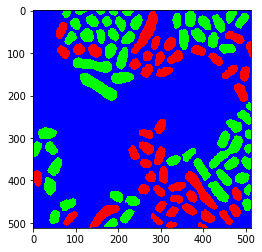

In [5]:
plt.imshow(labels[-1,:,:,:])
tf.__version__

(3, 512, 512) float32 float32


((9, 512, 512, 5), (9, 512, 512, 2))

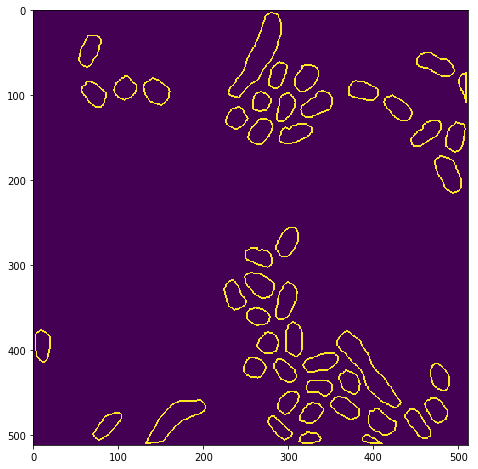

In [6]:

def get_outline(a, ch):
    
    b = a[:,:,ch] 
    b[np.where(b > 0)] = 1
    
    e0 = distance_transform_edt(b)
    ew = np.where(np.logical_and(e0 >= 1, e0 <=2))
    ew0 = np.zeros(b.shape, dtype=a.dtype)
    ew0[ew] = 1
    return ew0, ew

z = labels.copy()

ch4= np.zeros((labels.shape[0:-1] + (labshape[-1],)), dtype=np.float32)

for i in range(labels.shape[0]):
    ch = 0
    q0, qw0 = get_outline(labels[i], ch)
    z[i,:,:,0][qw0] = 0
    
    ch = 1
    q1, qw1 = get_outline(labels[i], ch)
    z[i,:,:,1][qw1] = 0
    
#     ch = 2
#     q2, qw2 = get_outline(labels[i], ch)
#     z[i,:,:,2][qw1] = 0
    
#     ch = 3
#     q3, qw3 = get_outline(labels[i], ch)
#     z[i,:,:,3][qw1] = 0
    
    ch4[i,:,:,0] = q0
    ch4[i,:,:,1] = q1
#     ch4[i,:,:,2] = q2
#     ch4[i,:,:,3] = q3

plt.figure(figsize=(8,8))
z = np.concatenate([z, ch4], axis=-1)
labels = z

print(labels[0,:,:,[0,1,3]].shape, ch4.dtype, labels.dtype)
plt.imshow(labels[-1,:,:,-2]) # + .5*labels[-1,:,:,4] + .25*labels[-1,:,:,-1])
labels.shape, labshape

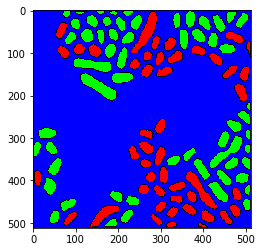

In [7]:
nv = -1
sh = [0,1,2]
pd = np.zeros((512, 512, 3), dtype=np.float32)
pd[:,:,0] = labels[nv, :,:,sh[0]]
pd[:,:,1] = labels[nv, :,:,sh[1]]
pd[:,:,2] = labels[nv ,:,:,sh[2]]
plt.imshow(pd)

In [8]:

tf.reset_default_graph()
u = dnet2d.dnet2d(params)
u.x = data
u.y = labels

In [9]:
test_images = imread('/scratch/cjw/Data/sez/test.tif')
tmean = test_images.mean(axis=(1,2),keepdims=True)
tstd = test_images.std(axis=(1,2),keepdims=True)

#data = (data_tif - dmin)/(dmax - dmin)
test_images = (test_images - tmean)/tstd
u.xtest = test_images
print(test_images.std(axis=(1,2)))
u.xtest.shape, u.xtest.mean(axis=(1,2)).shape,u.xtest.mean(axis=(1,2)), u.xtest.min(axis=(1,2)), u.xtest.max(axis=(1,2))

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


((4, 512, 512, 3),
 (4, 3),
 array([[ 8.67361738e-19,  4.33680869e-18, -1.47451495e-17],
        [ 2.42861287e-17, -2.77555756e-17,  1.73472348e-18],
        [-1.02999206e-17,  9.75781955e-18, -2.94902991e-17],
        [ 6.50521303e-18, -8.67361738e-18,  1.73472348e-17]]),
 array([[-0.77434923, -0.67069198, -5.75321835],
        [-0.80996298, -0.51847166, -5.15309134],
        [-1.16963105, -0.85580761, -4.75164339],
        [-1.44531311, -0.77003683, -4.44155761]]),
 array([[ 6.24956098,  6.31317096,  7.96252817],
        [ 8.99004117,  7.3174952 ,  6.62614886],
        [ 6.19657008,  5.88927642,  6.74214584],
        [10.81873288, 10.72657588,  6.89048635]]))

In [10]:
w = 256

In [11]:
tf.reset_default_graph()
images = tf.placeholder(tf.float32, (None, w, w, params['nchannels']))
masks = tf.placeholder(tf.float32, (None, w, w, labels.shape[-1]))
learning_rate = tf.placeholder(tf.float32, ())
u.learning_rate = learning_rate

In [12]:
enc = u.create_dnet(images, True)

W0213 17:22:36.577825 140688031659840 deprecation.py:323] From /home/cjw/Code/Unet/dnet/dnet2d.py:63: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.keras.layers.Conv2D instead.
W0213 17:22:36.582639 140688031659840 deprecation.py:506] From /home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1253: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


[16, 1, 1] <class 'int'>
Tensor("net-layer-0-0/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("net-layer-0/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("Placeholder:0", shape=(?, 256, 256, 3), dtype=float32)
----
[16, 3, 1] <class 'int'>
Tensor("net-layer-1-0/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("net-layer-1/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("net-layer-0/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
----
[16, 3, 2] <class 'int'>
Tensor("net-layer-2-0/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("net-layer-2/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("add:0", shape=(?, 256, 256, 16), dtype=float32)
----
[16, 3, 4] <class 'int'>
Tensor("net-layer-3-0/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("net-layer-3/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("add_1:0", shape=(?, 256, 256, 16), dtype=float32)
----
[16, 3, 6] <class 'int'>
Tensor("net-layer-4-0/

W0213 17:22:36.773572 140688031659840 deprecation.py:506] From /home/cjw/Code/Unet/dnet/dnet2d.py:90: calling softmax (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead


Tensor("net-layer-4/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("add_2:0", shape=(?, 256, 256, 16), dtype=float32)
----
[16, 3, 8] <class 'int'>
Tensor("net-layer-5-0/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("net-layer-5/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("add_3:0", shape=(?, 256, 256, 16), dtype=float32)
----
[5, 1, 1] <class 'int'>
Tensor("net-layer-6-0/BiasAdd:0", shape=(?, 256, 256, 5), dtype=float32)
Tensor("net-layer-6/BiasAdd:0", shape=(?, 256, 256, 5), dtype=float32)
Tensor("net-layer-5/BiasAdd:0", shape=(?, 256, 256, 16), dtype=float32)
----


In [13]:
u.net

<tf.Tensor 'encoder-5:0' shape=(?, 256, 256, 5) dtype=float32>

In [14]:
#d = u.create_decoder()
u.create_loss(masks)
u.create_opt()

W0213 17:22:36.807433 140688031659840 deprecation.py:506] From /home/cjw/Code/Unet/dnet/dnet2d.py:157: calling softmax_cross_entropy_with_logits_v2_helper (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead
W0213 17:22:37.018544 140688031659840 deprecation.py:506] From /home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
#u.set_validation(20)
u.xtrain = u.x

In [16]:
sess = tf.Session()

In [17]:
# tf.summary.scalar('loss', u.loss)
# si = tf.slice(u.decoder, [5, 0, 0, 0, 0], [10,1,256,256, 1])

# si = si[:,:,:,:,0]
# print(si)
# tf.summary.image('res', si, max_outputs=1)    
# merged = tf.summary.merge_all()



# logdir = "logdir"
# logwriter = tf.summary.FileWriter(logdir, sess.graph)

In [18]:
sess.run(tf.global_variables_initializer())

(2, 256, 256, 3) (2, 256, 256, 5)


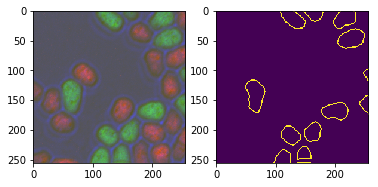

In [19]:
tb, tm = u.get_batch(2, erode=0)
tb = (tb - tb.min())/(tb.max() - tb.min())
print(tb.shape, tm.shape)
plt.subplot(1,2,1)
plt.imshow(tb[1,:,:,:])
plt.subplot(1,2,2)
plt.imshow(tm[-1,:,:,-1])

(256, 256, 5)


(256, 256)

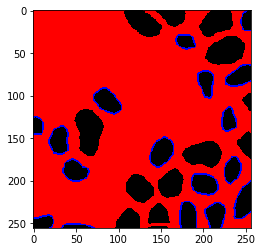

In [20]:
bz = tm[1]
print(bz.shape)
bz[:,:,-2] = 0

bzm = bz.max(axis=-1)
bz[:,:,-1] = 1 - bzm
plt.imshow(bz[:,:,-3:])
bzm.shape

In [21]:
u.stdev = 0.1
#u.learning_rate = 0.0001

0 1.6588849 1.6588849 0.037184678 0.64467245 0.0009994
4


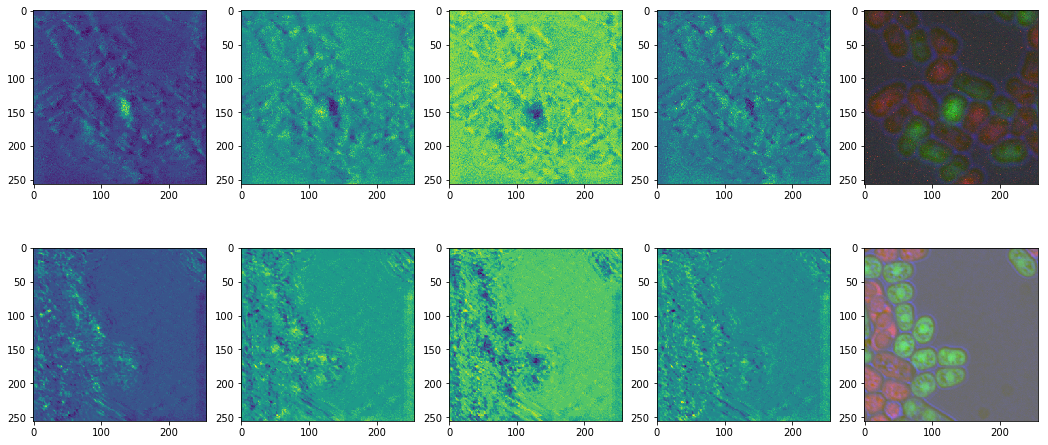

0 1.6588849 7.437635898590088 0.0009994
10 1.2151338 1.0651640892028809 0.0009934197644027314
20 0.77173126 1.0600476264953613 0.000987475313494075
30 0.6189561 0.9470608234405518 0.0009815664331446845
40 0.57843864 1.0547890663146973 0.0009756929105065258
50 0.4081115 0.9422874450683594 0.0009698545340052114
60 0.43185607 0.9497413635253906 0.0009640510933323775
70 0.3304199 0.9557082653045654 0.0009582823794381092
80 0.28172576 1.1494643688201904 0.0009525481845234097
90 0.2883551 1.2302501201629639 0.0009468483020327152
100 0.2956078 0.2956078 1.8376105e-16 0.9999958 0.0009411825266464541
12


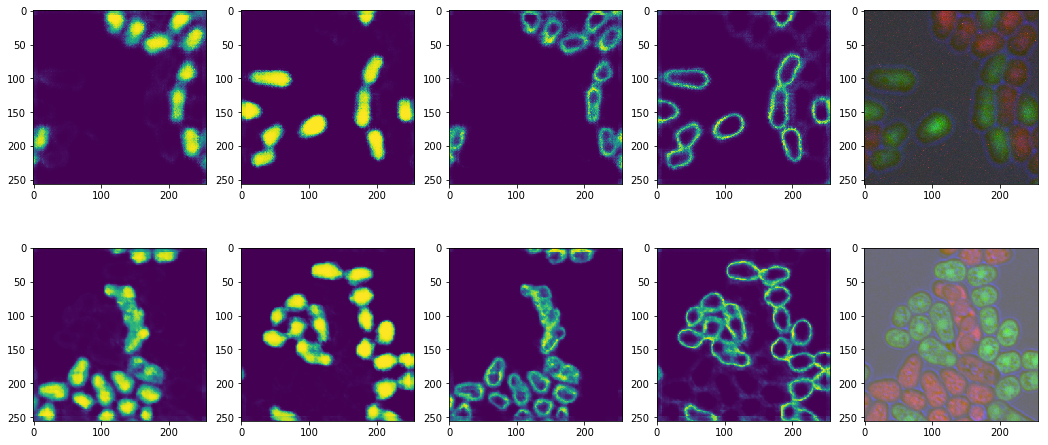

100 0.2956078 2.2560904026031494 0.0009411825266464541
110 0.25210983 1.6932029724121094 0.0009355506542736522
120 0.31046954 1.9806575775146484 0.0009299524820445797


In [ ]:

rate = 0.001
#loss_file = open('progress.dat', 'w', buffering=1)

tbx, _ = u.get_batch(16, test=True, erode=0)
for i in range(2500):
    t1 = time.time()
    rate = np.maximum(rate*.9994, 0.000005)
    bx, bm = u.get_batch(128, erode=0)
#     plt.figure(figsize=(2,2))
#     plt.imshow(bm[0])
    _, res, err = sess.run([u.opt, u.decoder_softmax, u.loss],
                           feed_dict={images:bx, masks:bm, learning_rate:rate})
    if i % 100 == 0:
        print(i, err, err, res[0,:,:,:].min(), res[0,:,:,:].max(), rate)
        nr = np.random.randint(0,16)
        #nr = np.argmin(res[:,:,:,4].sum(axis=(1,2)))
        print(nr)
        
        tres = sess.run(u.decoder_softmax,
                           feed_dict={images:tbx, learning_rate:rate})
        
        plt.figure(figsize=(18,8))
        plt.subplot(2,5,1)
        plt.imshow(res[nr,:,:,0])
        plt.subplot(2,5,2)
        plt.imshow(res[nr,:,:,1])
        plt.subplot(2,5,3)
        plt.imshow(res[nr,:,:,3])
        plt.subplot(2,5,4)
        plt.imshow(res[nr,:,:,4])
        plt.subplot(2,5,5)
        bxd = bx[nr,:,:,:]
        bxd = (bxd - bxd.min())/(bxd.max() - bxd.min())
        plt.imshow(bxd)
        
        plt.subplot(2,5,6)
        plt.imshow(tres[nr,:,:,0])
        plt.subplot(2,5,7)
        plt.imshow(tres[nr,:,:,1])
        plt.subplot(2,5,8)
        plt.imshow(tres[nr,:,:,3])
        plt.subplot(2,5,9)
        plt.imshow(tres[nr,:,:,4])
        plt.subplot(2,5,10)
        bxd = tbx[nr,:,:,:]
        bxd = (bxd - bxd.min())/(bxd.max() - bxd.min())
        plt.imshow(bxd)
        
    
#         plt.imshow(res[nr,:,:,5])
#         plt.subplot(2,5,7)
#         plt.imshow(res[nr,:,:,6])
#         plt.subplot(2,5,8)
#         plt.imshow(res[nr,:,:,7])
#         plt.subplot(2,5,9)
#         plt.imshow(res[nr,:,:,8])
#         plt.subplot(1,6,4)
#         plt.imshow(res[nr,:,:,1])
#         plt.subplot(1,6,5)
#         plt.imshow(bm[nr,:,:,1])
#         plt.subplot(1,6,6)
#         plt.imshow(bx[nr,:,:,1])
        plt.show()
        #plt.savefig("images/image{0:05d}".format(i))
    t2 = time.time()
    if i % 10 == 0:
        print(i, err, (t2 - t1), rate)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 256, 5)


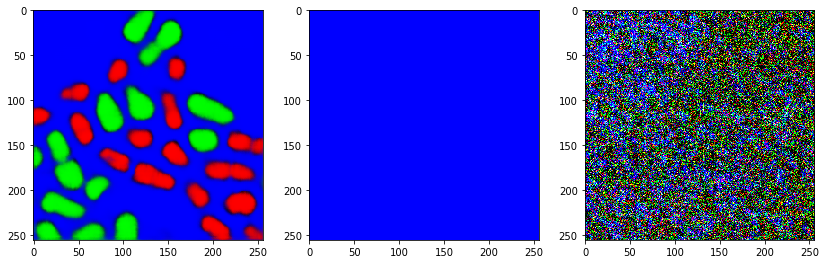

In [22]:
na = 13
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
print(bm.shape)
plt.imshow(res[na,:,:,0:3])
plt.subplot(1,3,2)
plt.imshow(bm[na,:,:,0:3])
plt.subplot(1,3,3)
plt.imshow(bx[na,:,:,:])


In [23]:
plt.hist(res[na,:,:,:].reshape((-1,3)))

ValueError: cannot reshape array of size 327680 into shape (3)

In [37]:
#test_tif = imread('/ssd1/cjw/Data/sez/RawTifs/16_hours_punched_overnight/NDExp_Point0008_Seq0008.tif')
test_tif = imread('/ssd1/cjw/Data/sez/RawTifs/NDExp_Point0007_Seq0007.tif')
#test_tif = labels[-1,:,:,:] #imread('/ssd1/cjw/Data/sez/RawTifs/NDExp_Point0021_Seq0021.tif')
ymax = test_tif.max(axis=(0,1), keepdims=True)
ymin = test_tif.min(axis=(0,1), keepdims=True)
ymean = test_tif.mean(axis=(0,1), keepdims=True)
ystd = test_tif.std(axis=(0,1), keepdims=True)
#test_tif = (test_tif - ymin)/(ymax - ymin + 0.00001)
test_tif = (test_tif - ymean)/ystd
test_tif.shape, ymin.shape

((2044, 2048, 3), (1, 1, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


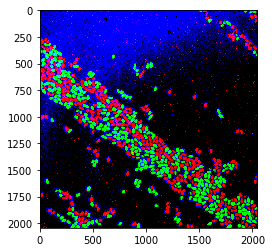

In [38]:
plt.imshow(test_tif)

In [39]:
def make_batch(data, start = 0):
    tclist = list()
    print(start)
    ix = start
    jy = start
    for i in range(6):
        jy = start
        for j in range(6):
            p = data[jy:jy + 256, ix:ix + 256,:]
            p = np.expand_dims(p, 0)
            tclist.append(p)
            jy = jy + 256
            #print(i, j, ix, jy)
        ix += 256

    tc = np.concatenate(tclist, axis=0)
    return tc

tc0 = make_batch(test_tif,start=0)
tc1 = make_batch(test_tif, start=128)
tc0.shape, tc1.shape

0
128


((36, 256, 256, 3), (36, 256, 256, 3))

In [40]:
vres0 = sess.run(u.decoder_softmax,
                feed_dict={images:tc0})

vres1 = sess.run(u.decoder_softmax,
                feed_dict={images:tc1})
vres0.shape, vres1.shape

((36, 256, 256, 5), (36, 256, 256, 5))

In [41]:
def reconstruct(v1, w, nx, ny, offset=0, pad=0):
    p = np.zeros((ny*w + pad, nx*w + pad, 5), dtype=np.float32)

    ix = offset
    jy = offset
    index = 0
    for i in range(nx):
        jy = offset
        for j in range(ny):
            p[jy:jy + 256, ix:ix + 256, :] = v1[index]
            jy = jy + 256
            index += 1
            #print(i, j, ix, jy)
        ix += 256
    return p
r0 = reconstruct(vres0, 256, 6, 6, offset=0, pad=128)
r1 = reconstruct(vres1, 256, 6, 6, offset=128, pad = 128)

r0 = np.expand_dims(r0, 0)
r1 = np.expand_dims(r1, 0)
r = np.concatenate([r0, r1])
r  = r.max(axis=(0))
r.shape, r.max()

((1664, 1664, 5), 1.0)

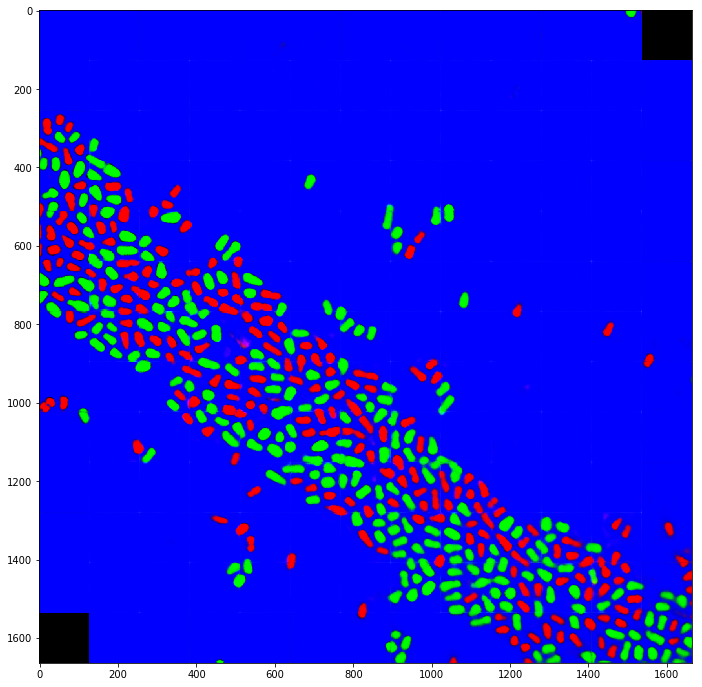

In [42]:

plt.figure(figsize=(12,12))

# az = r*0
# az[:,:,0] = r[:,:,-1]
# az[:,:,1] = r[:,:,-1]
# az[:,:,2] = r[:,:,-1]
# az = r - az

#plt.subplot(1,3,1)
plt.imshow(r[:,:,0:3]) #0[0,150:350,100:300,1])

#plt.subplot(1,3,4)
#plt.imshow(r0[0]) #[0,150:350,100:300,1])

#plt.subplot(1,3,3)
#plt.imshow(r1[0]) #[150:350,100:300,1])

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(test_tif[0:6*256+128, 0:6*256+128, :])

In [ ]:
plt.imshow(tc0[0,:,:,0])

In [ ]:
import tifffile
r.shape

In [ ]:
tifffile.imsave('/ssd1/cjw/Data/sez/unetout0017-2.tif', np.moveaxis(r, -1, 0))

In [ ]:
from skimage.morphology import binary_erosion

blab = labels[2, :,:,1]
plt.subplot(1,2,1)
plt.imshow(blab)
plt.subplot(1,2,2)
plt.imshow(binary_erosion(binary_erosion(blab)))
labels.shape

In [ ]:
plt.imshow(data[6,:,:,0:3])

In [ ]:
!%mkdir '/ssd1/cjw/sez/unet_checkpoint'

In [30]:
saver = tf.train.Saver()
saver.save(sess, '/ssd1/cjw/sez/Checkpoints/2019-02-04-zero-mean/unet_checkpoint', global_step=5000)

'/ssd1/cjw/sez/Checkpoints/2019-02-04-zero-mean/unet_checkpoint-5000'